# Analysing the MCMC binary fraction results

This Jupyter notebook produces some simple analysis figures to get an idea of the unresolved binary fraction in open clusters. Some of those figures are also in our paper.

In [15]:
import os
import numpy as np
from astropy.table import Table, vstack, join, hstack
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
import corner

import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from matplotlib import rcParams
rcParams["xtick.labelsize"] = 13
rcParams["ytick.labelsize"] = 13

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14}

from scipy.stats import linregress

## Read data

In [25]:
# Cantat-Gaudin+2020 catalogue (Table 1)
nntable = Table.read("data/CantatGaudin2020_table1.fits")
nntable["Cluster"]  = np.array([np.char.strip(a, ' ') for a in nntable["Cluster"]], dtype="S17")
# Results of our analysis:
finaltable = Table.read("data/Catalogue_observed_251_OCs_binaryfraction.fits")

## Figure 1: Galactic XY map + age distribution

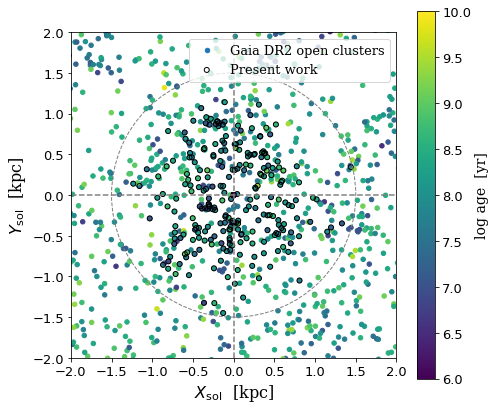

In [9]:
fig = plt.figure(figsize=(7,6))
ax  = plt.subplot(111)
xrange=(-2.,2.)
yrange=(-2.,2.)
plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
ax.set_xlabel(r"$X_{\rm sol}$  [kpc]", fontsize=16, fontdict=font)
ax.set_ylabel(r"$Y_{\rm sol}$  [kpc]", fontsize=16, fontdict=font)

# Overplot the completeness limit inherited from Tarricq+2022
circle1 = plt.Circle((0, 0), 1.5, color='grey', ls="--", fill=False)
ax.add_artist(circle1)
# plot some lines
plt.axhline(0., color='grey', ls="--")
plt.axvline(0., color='grey', ls="--")
# Data
sc = ax.scatter(nntable["X"]/1000., nntable["Y"]/1000., marker="o", c=nntable["AgeNN"], 
                vmin=6, vmax=10, s=20, label="Gaia DR2 open clusters")
ax.scatter(finaltable["X"]/1000., finaltable["Y"]/1000., marker="o", facecolors='none', 
           edgecolors='k', s=25, label="Present work")

plt.legend(loc="upper right", prop={"family":"serif", 'size': 13})
# Colour bar
cb = plt.colorbar(sc)
cb.set_label('log age  [yr]', fontdict=font)
ax.set_aspect('equal')
    
plt.tight_layout()
plt.savefig("im/spatial_distrib.png", dpi=300)

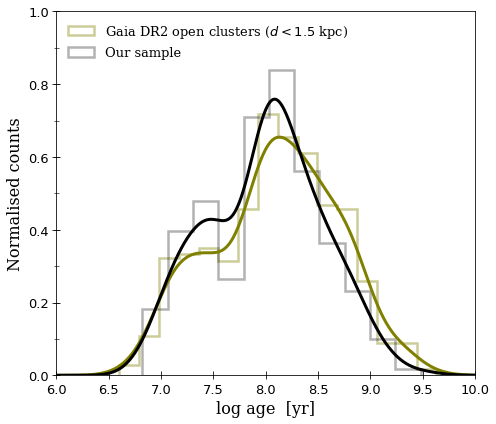

In [10]:
import seaborn as sns

fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([6,10,0.,1.0])
ax.set_xlabel(r"log age  [yr]", fontsize=16, fontdict=font)
ax.set_ylabel("Normalised counts", fontsize=16, fontdict=font)
#plt.title("Age distribution", fontsize=16)
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# --------------------------------------
# Add age histogram for CG+2020
agevals  = nntable["AgeNN"][(nntable["DistPc"]<1500) & (nntable["AgeNN"] > 0)]
vals, bins, patches = plt.hist(agevals, density=True, histtype="step", bins="fd", lw=2.5,
                               label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.4, color="olive")
kde = gaussian_kde(agevals, bw_method="scott")
kdearr = np.linspace(6,10,1000)
plt.plot(kdearr, kde.evaluate(kdearr), c="olive", lw=3)

# --------------------------------------
# Add age histogram for our sample
agevals  = finaltable["AgeNN"][(finaltable["DistPc"]<1500) & (finaltable["AgeNN"] > 0)]#.filled()
vals, bins, patches = plt.hist(agevals, density=True, histtype="step", bins="fd", lw=2.5,
                               label="Our sample", alpha=.3, color="k")
# Draw the kernel-estimated PDF for our sample
kde = gaussian_kde(agevals, bw_method="scott")
kdearr = np.linspace(6,10,1000)
plt.plot(kdearr, kde.evaluate(kdearr), c="k", lw=3)

plt.legend(loc="upper left", prop={"family":"serif", 'size': 13}, framealpha=0.0)

plt.tight_layout()
plt.savefig("im/age_histo.png", dpi=300)

## Figure 6: corner plot of the results for observed and simulated catalogues

187


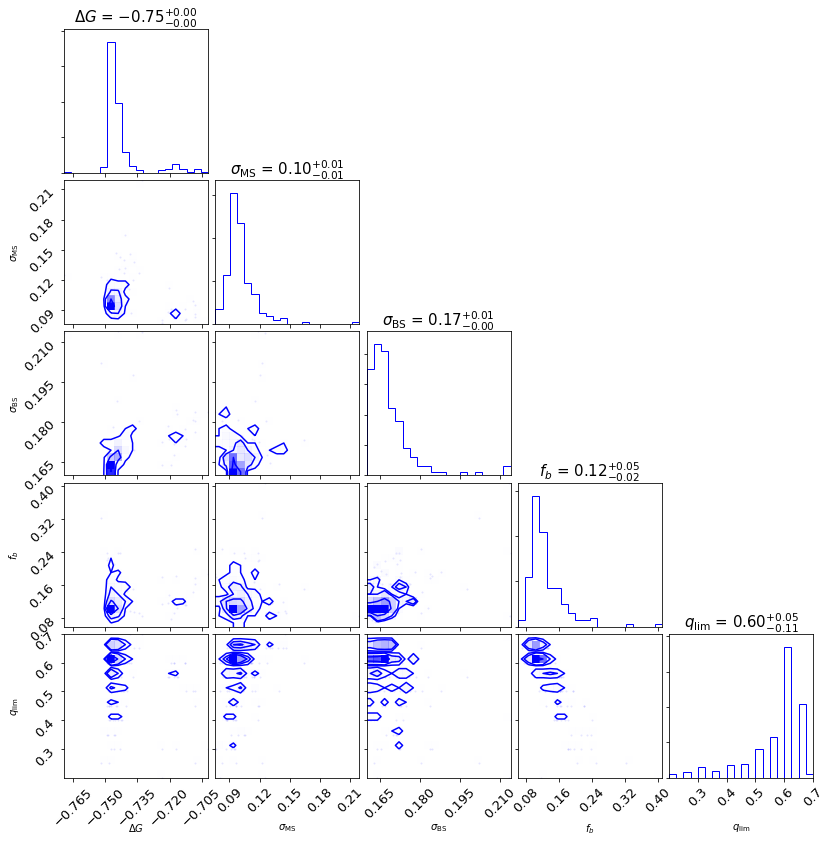

In [18]:
# Results for the simulated clusters
sim_OCs = Table.read("data/Catalogue_simulated_324OCs.fits")
# Define OK clusters
ok = (abs(sim_OCs["mean_DG_50"]+0.75) < 0.05) * \
     (sim_OCs["mean_sB_50"] < 0.22) 
print(sum(ok))
labels = [r"$\Delta G$", r"$\sigma_{\rm MS}$", r"$\sigma_{\rm BS}$", r"$f_b$", r"$q_{\rm lim}$", ]
fig = corner.corner(np.vstack([sim_OCs["mean_DG_50"], sim_OCs["mean_sM_50"], 
                               sim_OCs["mean_sB_50"], sim_OCs["mean_fb_50"], 
                               sim_OCs["m_r_closer_BF_to_sim_MCMC"]]).T[ok],
                    labels=labels, show_titles=True, title_kwargs={"fontsize": 15}, color="b")
plt.savefig("./im/corner_ok_sims.png", dpi=300)

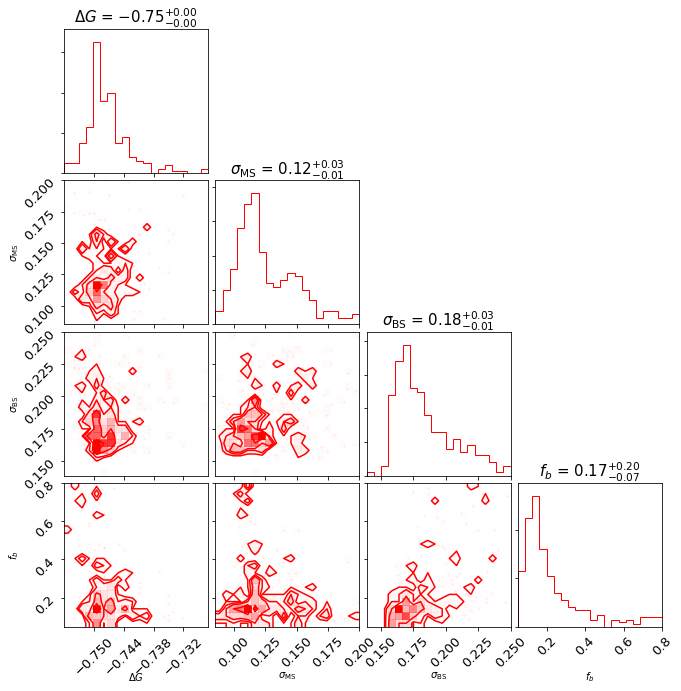

In [19]:
fig = corner.corner(np.vstack([finaltable["DG_50"], finaltable["sM_50"], 
                               finaltable["sB_50"], finaltable["fb_50"]]).T,
                    labels=labels[:-1], show_titles=True, title_kwargs={"fontsize": 15}, 
                    color="r", reverse=True)
plt.savefig("./im/corner_ok_obs.png", dpi=300)

## MCMC fit statistics (Table 1)

In [20]:
# Observed OCs
print("Observed fb:", np.round(np.percentile(finaltable["fb_50"], [16,50,84]),2))
print("Observed sS:", np.round(np.percentile(finaltable["sM_50"], [16,50,84]),2))
print("Observed sB:", np.round(np.percentile(finaltable["sB_50"], [16,50,84]),2))
print("Observed DG:", np.round(np.percentile(finaltable["DG_50"], [16,50,84]),2))
print("-----")
# Simulated OCs
print("Simulated fb (fit OK):", np.round(np.percentile(sim_OCs[ok]["mean_fb_50"], [16,50,84]),2))
print("Simulated sS (fit OK):", np.round(np.percentile(sim_OCs[ok]["mean_sM_50"], [16,50,84]),2))
print("Simulated sB (fit OK):", np.round(np.percentile(sim_OCs[ok]["mean_sB_50"], [16,50,84]),2))
print("Simulated DG (fit OK):", np.round(np.percentile(sim_OCs[ok]["mean_DG_50"], [16,50,84]),2))

Observed fb: [0.1  0.17 0.37]
Observed sS: [0.1  0.12 0.15]
Observed sB: [0.16 0.18 0.21]
Observed DG: [-0.75 -0.75 -0.74]
-----
Simulated fb (fit OK): [0.1  0.12 0.16]
Simulated sS (fit OK): [0.09 0.1  0.11]
Simulated sB (fit OK): [0.16 0.17 0.17]
Simulated DG (fit OK): [-0.75 -0.75 -0.74]


## Figure 11: $f_b^{\rm tot}$ as a function of Galactic position

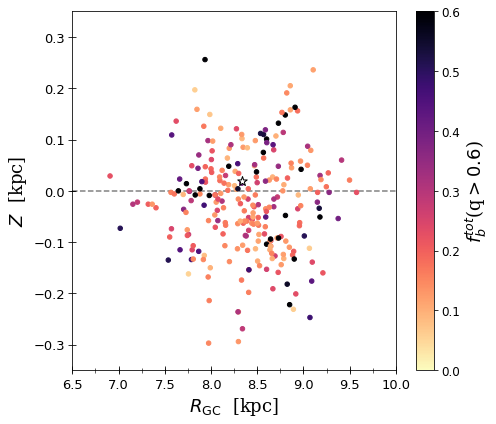

In [29]:
fig = plt.figure(figsize=(7,6))
ax  = plt.subplot(111)
xrange=(6.5,10.)
yrange=(-.350,.350)
plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])

ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.set_xlabel(r"$R_{\rm GC}$  [kpc]", fontdict=font, fontsize=18)
ax.set_ylabel(r"$Z$  [kpc]", fontdict=font, fontsize=18)

# Add reference z=0 line:
plt.axhline(0., color='grey', ls="--", zorder=0)

# Data and colour bar
sc = ax.scatter((finaltable["Rgc"])/(1000.), finaltable["Z"]/1000.,
                marker="o", c=finaltable["fb_tot_greater06"], vmin=0.0, 
                vmax=0.6, cmap="magma_r", s=20, label="_nolegend_")

cb = plt.colorbar(sc)
cb.set_label(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=18, fontdict=font)
cb.ax.tick_params(labelsize=12)
plt.scatter(8.34, 0.02, color="w", edgecolor="k", marker="*", s=100)
#plt.text(8.9,.430, "M 67", fontsize=13, fontdict=font)

#plt.legend(fontsize=14, framealpha=0.0, edgecolor="white") #loc='upper left', bbox_to_anchor=(0.0, 0.86)
plt.tight_layout()
plt.savefig("im/Z_Rgal_auxBF_tot.png", dpi=300)

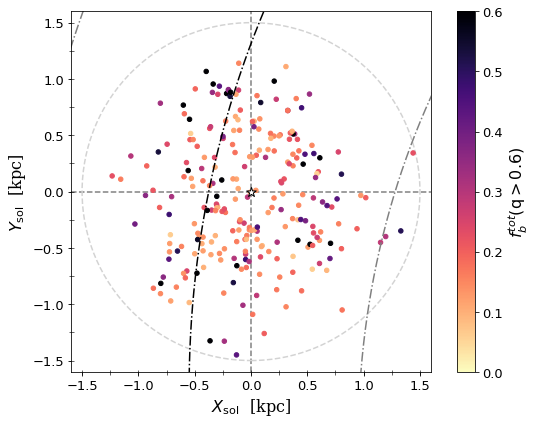

In [30]:
local_arm = Table.read("data/LocalfitsBO.fits")
perseus_arm = Table.read("data/PerseusBO.fits")
sag_car_arm = Table.read("data/Sgr-CarBO.fits")

fig = plt.figure(figsize=(8,6))
ax  = plt.subplot(111)
xrange=(-1.6,1.6)
yrange=(-1.6,1.6)
plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
ax.set_xlabel(r"$X_{\rm sol}$  [kpc]", fontsize=16, fontdict=font)
ax.set_ylabel(r"$Y_{\rm sol}$  [kpc]", fontsize=16, fontdict=font)
#plt.title("Analysed open clusters", fontsize=16)
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(which="minor", direction='inout', length=5.)

# plot some lines
plt.axhline(0., color='grey', ls="--", zorder=0)
plt.axvline(0., color='grey', ls="--", zorder=0)
circle1 = plt.Circle((0, 0), 1.5, color='lightgrey', ls="--", linewidth=1.5, fill=False, zorder=0)
ax.add_artist(circle1)
# Data
ax.plot(-(local_arm["Y_Gal"]-8.15), local_arm["X_Gal"], ls="dashdot", c="k", label="Local arm centre")
ax.plot(-(perseus_arm["Y_Gal"]-8.15), perseus_arm["X_Gal"], ls="dashdot", c="grey", label="Perseus arm centre")
ax.plot(-(sag_car_arm["Y_Gal"]-8.15), sag_car_arm["X_Gal"], ls="dashdot", c="grey", label="Sagg-Car arm centre")
sc = ax.scatter(finaltable["X"]/1000., finaltable["Y"]/1000., marker="o",
          c=finaltable["fb_tot_greater06"], vmin=0.0, vmax=0.6, cmap="magma_r", s=20, label="_nolegend_")
#plt.legend(loc="upper right", fontsize=14)
# Colour bar
cb = plt.colorbar(sc)
cb.set_label(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16)
ax.set_aspect('equal')
plt.scatter(0, 0., color="w", edgecolor="k", marker="*", s=100)
    
plt.tight_layout()
plt.savefig("im/spatial_distrib_XY_BF_tot_arms.png", dpi=300)

Alternatively, the binary fraction as a function of $R$ and $Z$ separately:

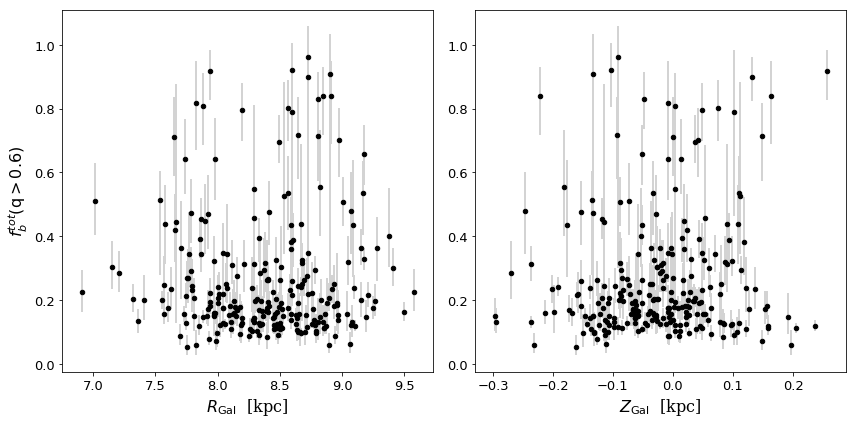

In [27]:
fig = plt.figure(figsize=(12,6))
### fb vs. R
ax = plt.subplot(121)
plt.errorbar((finaltable["Rgc"])/(1000.), finaltable["fb_tot_qlim06"],
             yerr=[finaltable["fb_tot_qlim06_sigl"],finaltable["fb_tot_qlim06_sigu"]], fmt='none',
             ecolor='lightgray', elinewidth=2, capsize=0, zorder=0)   #  fmt='none' to draw errorbars without any data markers
ax.scatter((finaltable["Rgc"])/(1000.), finaltable["fb_tot_qlim06"], 
                s=20, c="k")
ax.set_xlabel(r"$R_{\rm Gal}$  [kpc]", fontsize=16, fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16)
### fb vs. Z
ax = plt.subplot(122)
plt.errorbar((finaltable["Z"])/(1000.), finaltable["fb_tot_qlim06"],
             yerr=[finaltable["fb_tot_qlim06_sigl"],finaltable["fb_tot_qlim06_sigu"]], fmt='none',
             ecolor='lightgray', elinewidth=2, capsize=0, zorder=0)   #  fmt='none' to draw errorbars without any data markers
ax.scatter((finaltable["Z"])/(1000.), finaltable["fb_tot_qlim06"], 
                s=20, c="k")
ax.set_xlabel(r"$Z_{\rm Gal}$  [kpc]", fontsize=16, fontdict=font)
plt.tight_layout()
plt.savefig("im/RZ_BF_tot.png", dpi=300)

## Figure 11: $f_b^{\rm tot}$ as a function of mean stellar mass and distance

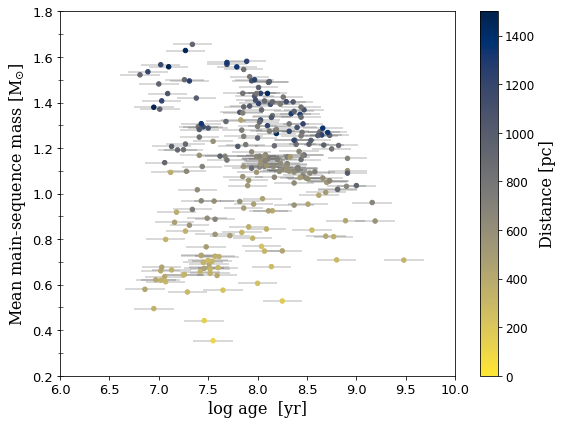

In [14]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.axis([6,10,0.2,1.8])
ax.set_xlabel(r"log age  [yr]", fontsize=16, fontdict=font)
ax.set_ylabel(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=16, fontdict=font)
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which="minor", direction='inout', length=5.)

plt.errorbar(finaltable["AgeNN"], finaltable["mean_mass"], c="k", xerr=0.2,
             fmt='none', capsize=None, alpha=0.2,  zorder=0)
sc = ax.scatter(finaltable["AgeNN"][ok], catalogue_obs_CantatTarricq["mean_mass"][ok],
                marker="o", c=catalogue_obs_CantatTarricq["DistPc"][ok], vmin=0, vmax=1500,
                s=20, label="_nolegend_", cmap="cividis_r", zorder=10)

cb = plt.colorbar(sc)
cb.set_label(r"Distance [pc]", fontsize=16, fontdict=font)
cb.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig("im/age_mean_mass_scatterplot_auxDistpc.png", dpi=300)

324 clusters with ages


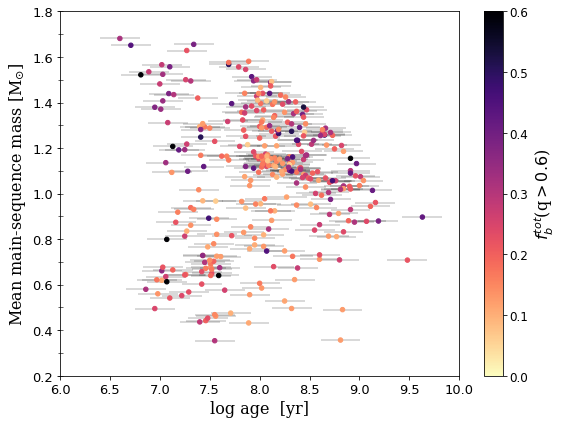

In [15]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.axis([6,10,0.2,1.8])
ax.set_xlabel(r"log age  [yr]", fontsize=16, fontdict=font)
ax.set_ylabel(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=16, fontdict=font)
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which="minor", direction='inout', length=5.)

ok = (catalogue_obs_CantatTarricq["AgeNN_1"] > 0) 
print(sum(ok), "clusters with ages")

plt.errorbar(catalogue_obs_CantatTarricq["AgeNN_1"][ok], catalogue_obs_CantatTarricq["mean_mass"][ok], c="k", xerr=0.2,
             fmt='none', capsize=None, alpha=0.2,  zorder=0)
sc = ax.scatter(catalogue_obs_CantatTarricq["AgeNN_1"][ok], catalogue_obs_CantatTarricq["mean_mass"][ok],
                marker="o", c=catalogue_obs_CantatTarricq["fb_tot_greater06"][ok], vmin=0.0, vmax=0.6,
                s=20, label="_nolegend_", cmap="magma_r", zorder=10)

cb = plt.colorbar(sc)
cb.set_label(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)
cb.ax.tick_params(labelsize=12)
plt.tight_layout()

plt.savefig("im/age_mean_mass_scatterplot_auxBFtot.png", dpi=300)

[57.5, 30.0, 50.0, 50.0, 50.0, 50.0, 50.0, 100.0, 100.0, 500.0]


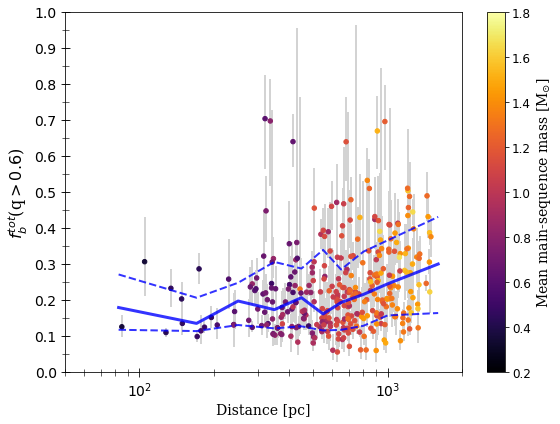

In [16]:
fig = plt.figure(figsize=(8,6))
ax  = plt.subplot(111)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(np.arange(0.00, 1.10, step=0.1), fontsize=14)
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(50, 2000)
plt.ylim(0.00,1.00)
ax.tick_params(which="major", direction='inout', length=9.)
ax.tick_params(which="minor", direction='inout', length=7.)
ax.set_xlabel(r"Distance [pc]", fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)

# Data and colour bar
plt.errorbar(catalogue_obs_CantatTarricq["DistPc"], catalogue_obs_CantatTarricq["fb_tot_greater06"],
             yerr=[catalogue_obs_CantatTarricq["fb_tot_greater06_sigl"],catalogue_obs_CantatTarricq["fb_tot_greater06_sigu"]], fmt='none',
             ecolor='lightgray', elinewidth=2, capsize=0, zorder=0)   #  fmt='none' to draw errorbars without any data markers
sc = ax.scatter(catalogue_obs_CantatTarricq["DistPc"], catalogue_obs_CantatTarricq["fb_tot_greater06"],
                marker="o", c=catalogue_obs_CantatTarricq["mean_mass"], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
cb = plt.colorbar(sc)
cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

# Overplot running median
bins = np.array([25., 140., 200., 300., 400., 500., 600., 700., 900., 1100., 2100.])
total_bins = len(bins)
deltas = [(bins[x+1]-bins[x])/2. for x in np.arange(0, len(bins)-1)]
print(deltas)
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(catalogue_obs_CantatTarricq["fb_tot_greater06"][(catalogue_obs_CantatTarricq["DistPc"] > bins[k]) & (catalogue_obs_CantatTarricq["DistPc"] < bins[k+1])],
                         [.16,.50,.84])
plt.plot(bins[:-1]+deltas,stat[:-1, 1],'b-', lw=3,alpha=.8, zorder=30)
plt.plot(bins[:-1]+deltas,stat[:-1, 2],'b--',lw=2,alpha=.8, zorder=30)
plt.plot(bins[:-1]+deltas,stat[:-1, 0],'b--',lw=2,alpha=.8, zorder=30)

plt.tight_layout()
plt.savefig("im/BF_tot_vs_dist-fit-auxmeanmass-runquantiles_correct.png", dpi=300)

[57.5, 30.0, 50.0, 50.0, 50.0, 50.0, 50.0, 100.0, 100.0, 500.0]


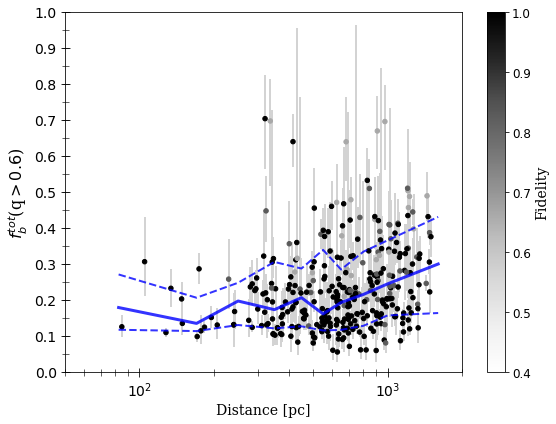

In [17]:
fig = plt.figure(figsize=(8,6))
ax  = plt.subplot(111)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(np.arange(0.00, 1.10, step=0.1), fontsize=14)
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(50, 2000)
plt.ylim(0.00,1.00)
ax.tick_params(which="major", direction='inout', length=9.)
ax.tick_params(which="minor", direction='inout', length=7.)
ax.set_xlabel(r"Distance [pc]", fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)

# Data and colour bar
plt.errorbar(catalogue_obs_CantatTarricq["DistPc"], catalogue_obs_CantatTarricq["fb_tot_greater06"],
             yerr=[catalogue_obs_CantatTarricq["fb_tot_greater06_sigl"],catalogue_obs_CantatTarricq["fb_tot_greater06_sigu"]], fmt='none',
             ecolor='lightgray', elinewidth=2, capsize=0, zorder=0)   #  fmt='none' to draw errorbars without any data markers
sc = ax.scatter(catalogue_obs_CantatTarricq["DistPc"], catalogue_obs_CantatTarricq["fb_tot_greater06"],
                marker="o", c=catalogue_obs_CantatTarricq["Fidelity"], vmin=0.4, vmax=1.0,
                s=20, label="_nolegend_", cmap="Greys", zorder=10)
cb = plt.colorbar(sc)
cb.set_label('Fidelity', fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

# Overplot running median
bins = np.array([25., 140., 200., 300., 400., 500., 600., 700., 900., 1100., 2100.])
total_bins = len(bins)
deltas = [(bins[x+1]-bins[x])/2. for x in np.arange(0, len(bins)-1)]
print(deltas)
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(catalogue_obs_CantatTarricq["fb_tot_greater06"][(catalogue_obs_CantatTarricq["DistPc"] > bins[k]) & (catalogue_obs_CantatTarricq["DistPc"] < bins[k+1])],
                         [.16,.50,.84])
plt.plot(bins[:-1]+deltas,stat[:-1, 1],'b-', lw=3,alpha=.8, zorder=30)
plt.plot(bins[:-1]+deltas,stat[:-1, 2],'b--',lw=2,alpha=.8, zorder=30)
plt.plot(bins[:-1]+deltas,stat[:-1, 0],'b--',lw=2,alpha=.8, zorder=30)

plt.tight_layout()
plt.savefig("im/BF_tot_vs_dist-fit-auxfid-runquantiles.png", dpi=300)

## Figure 12: $f_b^{\rm tot}$ vs. age

First the overall plot for the observed OCs (top left panel):

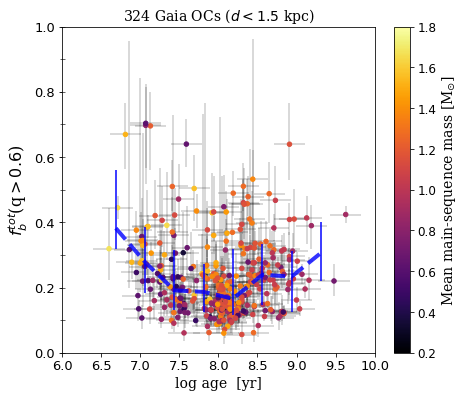

In [18]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([6,10,0,1.00])
ax.set_xlabel(r"log age  [yr]", fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which="minor", direction='inout', length=5.)

plt.errorbar(catalogue_obs_CantatTarricq["AgeNN_1"][ok], catalogue_obs_CantatTarricq["fb_tot_greater06"][ok], c="k", xerr=0.2,
             yerr=[catalogue_obs_CantatTarricq["fb_tot_greater06_sigl"][ok],catalogue_obs_CantatTarricq["fb_tot_greater06_sigu"][ok]], 
             label=r"OCs with $\sigma_{f_b}<0.15$", fmt='none', capsize=None, alpha=0.2,  zorder=0)
sc = ax.scatter(catalogue_obs_CantatTarricq["AgeNN_1"][ok], catalogue_obs_CantatTarricq["fb_tot_greater06"][ok],
                marker="o", c=catalogue_obs_CantatTarricq["mean_mass"], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
cb = plt.colorbar(sc)
cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

plt.title(r"324 Gaia OCs ($d<1.5$ kpc)", fontdict=font)

# Overplot running median
total_bins = 9
bins = np.linspace(6.5, 9.5, total_bins)
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(catalogue_obs_CantatTarricq["fb_tot_greater06"][ok & (catalogue_obs_CantatTarricq["AgeNN_1"] > bins[k]) & (catalogue_obs_CantatTarricq["AgeNN_1"] < bins[k+1])],
                         [.16,.50,.84])
plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)

plt.savefig("im/age_BF_tot_scatterplot_auxmeanmass.png", dpi=300)

Then the 4 mean mass bins:

21 clusters with ages and ok f_b uncertainties
90 clusters with ages and ok f_b uncertainties
173 clusters with ages and ok f_b uncertainties
40 clusters with ages and ok f_b uncertainties


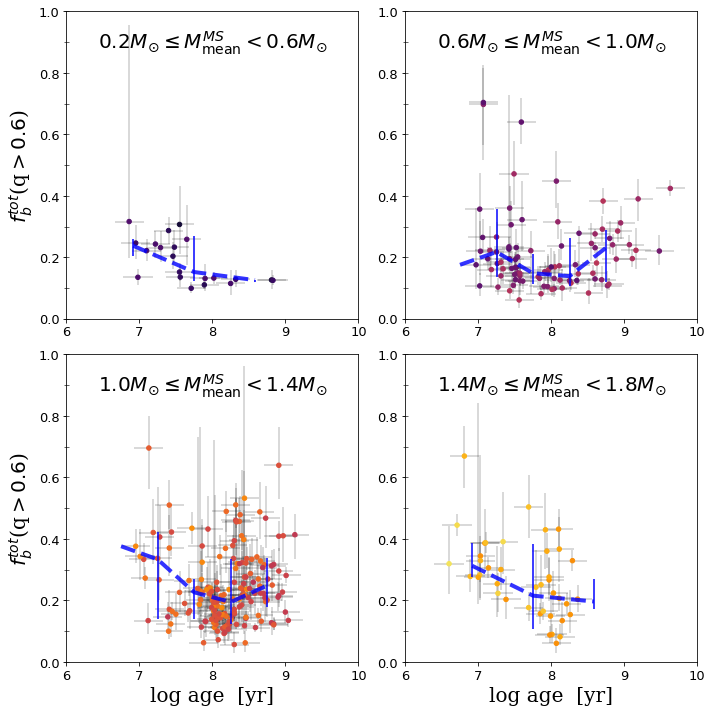

In [19]:
fig = plt.figure(figsize=(10,10))

massranges = [[.2,.6], [0.6,1.], [1.,1.4], [1.4,1.8]]
total_bins = [4,6,6,4]

for ii in [1,2,3,4]:
    ax = plt.subplot(2, 2, ii)

    plt.axis([6,10,0,1.00])
    if ii > 2:
        ax.set_xlabel(r"log age  [yr]", fontsize=20, fontdict=font)
    if ii in [1,3]:
        ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=20, fontdict=font)

    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(which="minor", direction='inout', length=5.)

    ok = (catalogue_obs_CantatTarricq["mean_mass"]  > massranges[ii-1][0]) & \
         (catalogue_obs_CantatTarricq["mean_mass"] <= massranges[ii-1][1])
    print(sum(ok), "clusters with ages and ok f_b uncertainties")
    plt.text(0.5,.9, str(massranges[ii-1][0])+r"$M_{\odot}\leq M_{\rm mean}^{MS}<$"+str(massranges[ii-1][1])+r"$M_{\odot}$", 
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20)

    plt.errorbar(catalogue_obs_CantatTarricq["AgeNN_1"][ok], catalogue_obs_CantatTarricq["fb_tot_greater06"][ok], c="k", xerr=0.2,
             yerr=[catalogue_obs_CantatTarricq["fb_tot_greater06_sigl"][ok],catalogue_obs_CantatTarricq["fb_tot_greater06_sigu"][ok]], 
             label=r"OCs with $\sigma_{f_b}<0.15$", fmt='none', capsize=None, alpha=0.2,  zorder=0)
    sc = ax.scatter(catalogue_obs_CantatTarricq["AgeNN_1"][ok], catalogue_obs_CantatTarricq["fb_tot_greater06"][ok],
                marker="o", c=catalogue_obs_CantatTarricq["mean_mass"][ok], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)

    # Overplot running median
    bins = np.linspace(6.5, 9., total_bins[ii-1])
    delta = bins[1]-bins[0]
    stat = np.zeros((total_bins[ii-1], 3))   # list of total_bins elements, with 3 elements each

    # automatic calculation of the quantiles:
    for k in np.arange(total_bins[ii-1]-1):
        stat[k,:] = np.quantile(catalogue_obs_CantatTarricq["fb_tot_greater06"][ok & (catalogue_obs_CantatTarricq["AgeNN_1"] > bins[k]) & (catalogue_obs_CantatTarricq["AgeNN_1"] < bins[k+1])],
                             [.16,.50,.84])
    # y axis has the middle component (50th percentile, median) for all rows: for all middeling positions of the bins.
    plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
    # it also plots the 9th errorbar, but as it is full of 0's, we don't see it.
    # It si necessary to plot bins without the last element, because for this no stats is calculated (it is the last right border)
    plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)

plt.tight_layout()
plt.savefig("im/age_BF_tot_scatterplot_4meanmassranges.png", dpi=300)

And now the same for the simulated clusters:

241 simulated clusters with ages and ok fits


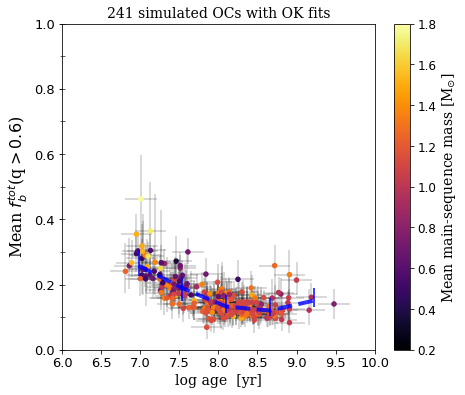

In [20]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([6.0,10,0,1.])
ax.set_xlabel(r"log age  [yr]", fontdict=font)
ax.set_ylabel(r"Mean $f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which="minor", direction='inout', length=5.)

ok = (sim_OCs_MCMC_GMM["logAge"] > 0) & (sim_OCs_MCMC_GMM["mean_DG_50"] < -0.55) 
print(sum(ok), "simulated clusters with ages and ok fits")

plt.errorbar(sim_OCs_MCMC_GMM["logAge"][ok], sim_OCs_MCMC_GMM["mean_fb_tot_greater06"][ok], c="k", xerr=0.2,
             yerr=[sim_OCs_MCMC_GMM["mean_fb_tot_greater06_sigl"][ok],
                   sim_OCs_MCMC_GMM["mean_fb_tot_greater06_sigu"][ok]], 
             label=r"OCs with $\sigma_{f_b}<0.15$", fmt='none', capsize=None, alpha=0.2,  zorder=0)
sc = ax.scatter(sim_OCs_MCMC_GMM["logAge"][ok], sim_OCs_MCMC_GMM["mean_fb_tot_greater06"][ok],
                marker="o", c=sim_OCs_MCMC_GMM[ok]["mean_mass"], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
cb = plt.colorbar(sc)
cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

plt.title(r""+str(sum(ok))+" simulated OCs with OK fits", fontdict=font)

# Overplot running median
total_bins = 6
bins = np.linspace(6.7, 9.5, total_bins)
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(sim_OCs_MCMC_GMM["mean_fb_tot_greater06"][ok & (sim_OCs_MCMC_GMM["logAge"] > bins[k]) & (sim_OCs_MCMC_GMM["logAge"] < bins[k+1])],
                         [.16,.50,.84])
plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)

plt.savefig("im/sim_age_BF_tot_scatterplot_auxmeanmass.png", dpi=300)

15 sim clusters with ok f_b uncertainties
44 sim clusters with ok f_b uncertainties
165 sim clusters with ok f_b uncertainties
17 sim clusters with ok f_b uncertainties


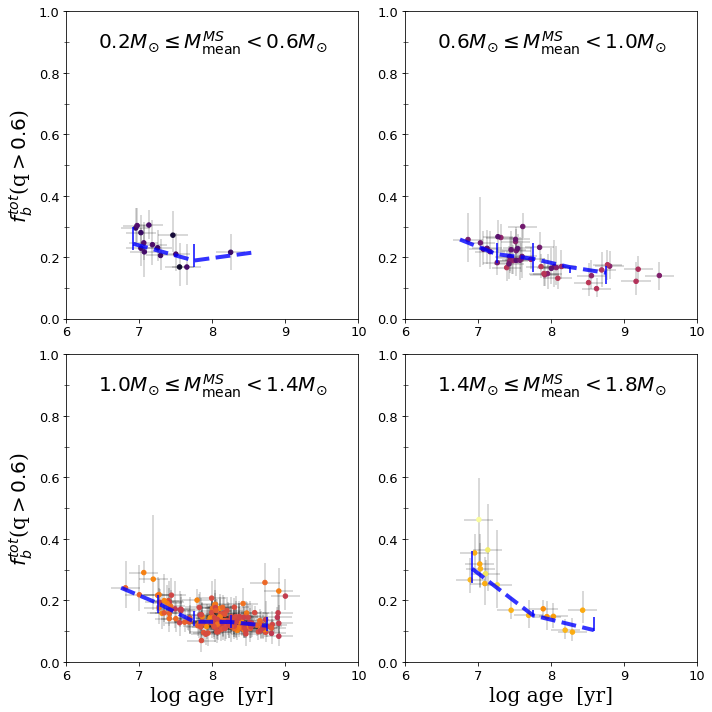

In [21]:
fig = plt.figure(figsize=(10,10))

massranges = [[.2,.6], [0.6,1.], [1.,1.4], [1.4,1.8]]
total_bins = [4,6,6,4]

for ii in [1,2,3,4]:
    ax = plt.subplot(2, 2, ii)

    plt.axis([6,10,0,1.00])
    if ii > 2:
        ax.set_xlabel(r"log age  [yr]", fontsize=20, fontdict=font)
    if ii in [1,3]:
        ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=20, fontdict=font)

    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(which="minor", direction='inout', length=5.)

    ok = (sim_OCs_MCMC_GMM["mean_mass"]  > massranges[ii-1][0]) & \
         (sim_OCs_MCMC_GMM["mean_mass"] <= massranges[ii-1][1]) & \
         (sim_OCs_MCMC_GMM["mean_DG_50"] < -0.55)
    print(sum(ok), "sim clusters with ok f_b uncertainties")
    plt.text(0.5,.9, str(massranges[ii-1][0])+r"$M_{\odot}\leq M_{\rm mean}^{MS}<$"+str(massranges[ii-1][1])+r"$M_{\odot}$", 
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20)

    plt.errorbar(sim_OCs_MCMC_GMM["logAge"][ok], sim_OCs_MCMC_GMM["mean_fb_tot_greater06"][ok], c="k", xerr=0.2,
                 yerr=[sim_OCs_MCMC_GMM["mean_fb_tot_greater06_sigl"][ok],sim_OCs_MCMC_GMM["mean_fb_tot_greater06_sigu"][ok]], 
                 label=r"OCs with $\sigma_{f_b}<0.15$", fmt='none', capsize=None, alpha=0.2,  zorder=0)
    sc = ax.scatter(sim_OCs_MCMC_GMM["logAge"][ok], sim_OCs_MCMC_GMM["mean_fb_tot_greater06"][ok],
                    marker="o", c=sim_OCs_MCMC_GMM["mean_mass"][ok], vmin=0.2, vmax=1.8,
                    s=20, label="_nolegend_", cmap="inferno", zorder=10)

    # Overplot running median
    bins = np.linspace(6.5, 9., total_bins[ii-1])
    delta = bins[1]-bins[0]
    stat = np.zeros((total_bins[ii-1], 3))   # list of total_bins elements, with 3 elements each

    # automatic calculation of the quantiles:
    for k in np.arange(total_bins[ii-1]-1):
        stat[k,:] = np.quantile(sim_OCs_MCMC_GMM["mean_fb_tot_greater06"][ok & (sim_OCs_MCMC_GMM["logAge"] > bins[k]) & (sim_OCs_MCMC_GMM["logAge"] < bins[k+1])],
                             [.16,.50,.84])
    # y axis has the middle component (50th percentile, median) for all rows: for all middeling positions of the bins.
    plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
    # it also plots the 9th errorbar, but as it is full of 0's, we don't see it.
    # It si necessary to plot bins without the last element, because for this no stats is calculated (it is the last right border)
    plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)

plt.tight_layout()
plt.savefig("im/sim_age_BF_tot_scatterplot_4meanmassranges.png", dpi=300)

## Figure 13: $f_b^{\rm tot}$ vs. number of main-sequence members

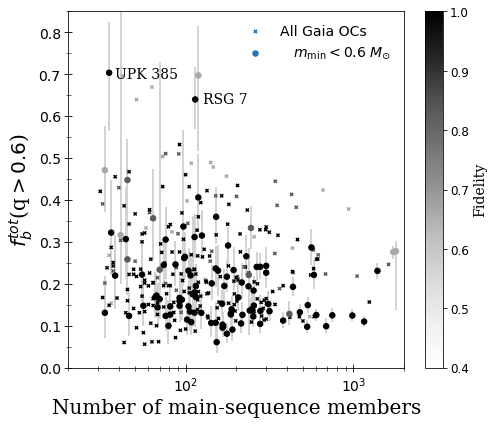

In [22]:
fig = plt.figure(figsize=(7,6))
ax  = plt.subplot(111)
#xrange=(-2.,2.)
#yrange=(-2.,2.)
#plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(np.arange(0.00, 0.90, step=0.1), fontsize=14)
#plt.tick_params(axis='x', which='minor')
#ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(20, 2000)
plt.ylim(0.00,0.85)
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.set_xlabel(r"Number of main-sequence members", fontsize=20, fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=20, fontdict=font)

long_ms = (catalogue_obs_CantatTarricq["mass_min"] < 0.6)

# Data and colour bar
ax.scatter(catalogue_obs_CantatTarricq["nb_MS_members"], catalogue_obs_CantatTarricq["fb_tot_greater06"],
                marker="x", c=catalogue_obs_CantatTarricq["Fidelity"], vmin=0.4, vmax=1.0,
                s=10, label="All Gaia OCs", cmap="Greys")

plt.errorbar(catalogue_obs_CantatTarricq["nb_MS_members"][long_ms], 
             catalogue_obs_CantatTarricq["fb_tot_greater06"][long_ms],
             yerr=[catalogue_obs_CantatTarricq["fb_tot_greater06_sigl"][long_ms],
                   catalogue_obs_CantatTarricq["fb_tot_greater06_sigu"][long_ms]],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=0, zorder=0 ,label = "_nolegend_")
sc = ax.scatter(catalogue_obs_CantatTarricq["nb_MS_members"][long_ms], 
                catalogue_obs_CantatTarricq["fb_tot_greater06"][long_ms],
                marker="o", c=catalogue_obs_CantatTarricq["Fidelity"][long_ms], vmin=0.4, vmax=1.0,
                s=30, label=r"   $m_{\rm min} < 0.6\ M_{\odot}$", cmap="Greys")
cb = plt.colorbar(sc)
cb.set_label('Fidelity', fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)
#sm.set_clim(vmin=0.0, vmax=2.2)
#cb = plt.colorbar(sm)
#cb.set_label('$A_V$  [mag]', fontsize=14, fontdict=font)
#cb.ax.tick_params(labelsize=12)
plt.annotate("RSG 7", (124, 0.64), xytext=(127, .63), xycoords='data', 
             textcoords=None, #arrowprops={"width":1, "headwidth":4.5, "color":"k"}, annotation_clip=None, 
             fontsize=14, fontfamily='serif')
plt.annotate("UPK 385", (35, 0.7), xytext=(38, .69), xycoords='data', 
             textcoords=None, #arrowprops={"width":1, "headwidth":4.5, "color":"k"}, annotation_clip=None, 
             fontsize=14, fontfamily='serif')

plt.legend(fontsize=14, framealpha=0.0, edgecolor="white", loc='upper right')
plt.tight_layout()
plt.savefig("im/BF_tot_vs_nbMSmem_auxfid.png", dpi=300)

## Figure 14: $f_b^{\rm tot}$ vs. metallicity from Gaia DR3 (GSP-Spec)

We retrieved the DR3 GSP-Spec metallicities for the "High-Quality sample" listed in Appendix B of Gaia Collaboration, Recio-Blanco et al. (2022), adding only an upper temperature limit of Teff < 8000 K:

Then this was cross-matched with the membership tables of Tarricq+2021 and Cantat-Gaudin+2020 ($P_{\rm memb} > 0.7$). Resulting in this table:

In [23]:
mhtable = Table.read("data/Cantat2020Tarricq2021_mhspec_DR3_highquality.fits")
mhtable["Cluster"] = [np.char.strip(a, ' ') for a in mhtable["Cluster"]]

Now let's do some statistics to extract a mean metallicity per cluster:

In [24]:
mh_ocs  = np.unique(np.array(mhtable["Cluster"]))
mean_mh = np.zeros(len(mh_ocs))
std_mh  = np.zeros(len(mh_ocs))
N_mh    = np.ones(len(mh_ocs))
catalogue_obs_CantatTarricq["M_H"]     = -9.99
catalogue_obs_CantatTarricq["sig_M_H"] = -9.99
catalogue_obs_CantatTarricq["N_M_H"]   = 0

for ii in np.arange(len(mh_ocs)):
    sel = mhtable["Cluster"] == mh_ocs[ii]
    mean_mh[ii] = np.mean(mhtable["mh_gspspec"][sel])
    if np.sum(sel) > 1:
        std_mh[ii] = np.maximum(np.std(mhtable["mh_gspspec"][sel]), 0.05)
        N_mh[ii]   = np.sum(sel)
    else:
        std_mh[ii] = np.maximum(mhtable["mh_gspspec"][sel], 0.05)
    # Add columns in the big table
    if mh_ocs[ii] in np.unique(np.array(catalogue_obs_CantatTarricq["Cluster"])):
        catalogue_obs_CantatTarricq["M_H"][catalogue_obs_CantatTarricq["Cluster"]==mh_ocs[ii]]     = mean_mh[ii]
        catalogue_obs_CantatTarricq["sig_M_H"][catalogue_obs_CantatTarricq["Cluster"]==mh_ocs[ii]] = std_mh[ii]
        catalogue_obs_CantatTarricq["N_M_H"][catalogue_obs_CantatTarricq["Cluster"]==mh_ocs[ii]]   = N_mh[ii]
        

In [25]:
print(len(mh_ocs), "OCs with mean GSP-Spec metallicities")
print(sum(catalogue_obs_CantatTarricq["M_H"]>-9.), "in our sample (", sum(catalogue_obs_CantatTarricq["N_M_H"]>2), "with 3 or more GSP-Spec stars)")


705 OCs with mean GSP-Spec metallicities
154 in our sample ( 54 with 3 or more GSP-Spec stars)


[-0.25 -0.15 -0.05  0.05  0.15  0.25]


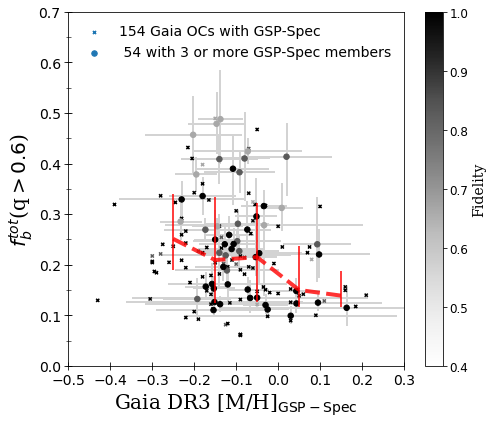

In [26]:
fig = plt.figure(figsize=(7,6))
ax  = plt.subplot(111)

plt.xticks(fontsize=14)
plt.yticks(np.arange(0.00, 0.90, step=0.1), fontsize=14)

ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(-.5,0.3)
plt.ylim(0,.7)
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.set_xlabel(r"Gaia DR3 [M/H]$_{\rm GSP-Spec}$", fontsize=20, fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=20, fontdict=font)

met = (catalogue_obs_CantatTarricq["M_H"]>-9.)
N3  = (catalogue_obs_CantatTarricq["N_M_H"]>2)

# Data and colour bar
ax.scatter(catalogue_obs_CantatTarricq["M_H"][met], catalogue_obs_CantatTarricq["fb_tot_greater06"][met],
                marker="x", c=catalogue_obs_CantatTarricq["Fidelity"][met], vmin=0.4, vmax=1.0,
                s=10, label="154 Gaia OCs with GSP-Spec", cmap="Greys")

plt.errorbar(catalogue_obs_CantatTarricq["M_H"][N3], 
             catalogue_obs_CantatTarricq["fb_tot_greater06"][N3],
             xerr=catalogue_obs_CantatTarricq["sig_M_H"][N3],
             yerr=[catalogue_obs_CantatTarricq["fb_tot_greater06_sigl"][N3],
                   catalogue_obs_CantatTarricq["fb_tot_greater06_sigu"][N3]],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=0, zorder=0 ,label = "_nolegend_")
sc = ax.scatter(catalogue_obs_CantatTarricq["M_H"][N3], 
                catalogue_obs_CantatTarricq["fb_tot_greater06"][N3],
                marker="o", c=catalogue_obs_CantatTarricq["Fidelity"][N3], vmin=0.4, vmax=1.0,
                s=30, label=r" 54 with 3 or more GSP-Spec members", cmap="Greys")
cb = plt.colorbar(sc)
cb.set_label('Fidelity', fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

# Overplot running median
total_bins = 5
bins = np.array([-.3,-.2,-.1,0,.1,.2])
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each
for k in np.arange(total_bins):
    stat[k,:] = np.quantile(catalogue_obs_CantatTarricq["fb_tot_greater06"] \
                            [met & (catalogue_obs_CantatTarricq["M_H"] > bins[k]) & \
                                   (catalogue_obs_CantatTarricq["M_H"] < bins[k+1])],
                            [.16,.50,.84])
print(bins+delta/2)
# y axis has the middle component (50th percentile, median) for all rows: for all middeling positions of the bins.
plt.errorbar(bins[:-1]+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="r", fmt="none", zorder=20)
# it also plots the 9th errorbar, but as it is full of 0's, we don't see it.
# It si necessary to plot bins without the last element, because for this no stats is calculated (it is the last right border)
plt.plot(bins[:-1]+delta/2,stat[:, 1],'r--',lw=4,alpha=.8, zorder=30)


plt.legend(fontsize=14, framealpha=0.0, edgecolor="white", loc='upper right')
plt.tight_layout()
plt.savefig("im/BF_tot_vs_mh_gspspec_auxfid.png", dpi=300)

A similar plot (but unfortunately with less clusters) can be done when crossmatching to the OC catalogue of Netopil+2022:

In [27]:
netopil_xmatched = Table.read("data/324OCs_x_Netopil2022.fits")

[-0.15 -0.05  0.05  0.15  0.25]


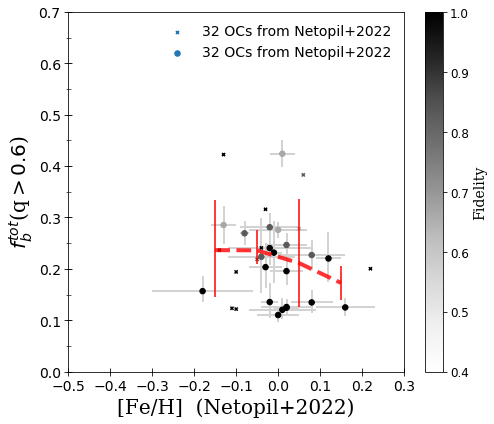

In [28]:
fig = plt.figure(figsize=(7,6))
ax  = plt.subplot(111)

plt.xticks(fontsize=14)
plt.yticks(np.arange(0.00, 0.90, step=0.1), fontsize=14)

ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(-.5,0.3)
plt.ylim(0,.7)
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.set_xlabel(r"[Fe/H]  (Netopil+2022)", fontsize=20, fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=20, fontdict=font)

N3 = (netopil_xmatched["Nstars"] > 2)

ax.scatter(netopil_xmatched["__Fe_H_"], 
                netopil_xmatched["fb_tot_greater06"],
                marker="x", c=netopil_xmatched["Fidelity"], vmin=0.4, vmax=1.0,
                s=10, label=r"32 OCs from Netopil+2022", cmap="Greys")
# Data and colour bar
plt.errorbar(netopil_xmatched["__Fe_H_"][N3], 
             netopil_xmatched["fb_tot_greater06"][N3],
             xerr=netopil_xmatched["e__Fe_H_"][N3],
             yerr=[netopil_xmatched["fb_tot_greater06_sigl"][N3],
                   netopil_xmatched["fb_tot_greater06_sigu"][N3]],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=0, zorder=0 ,label = "_nolegend_")
sc = ax.scatter(netopil_xmatched["__Fe_H_"][N3], 
                netopil_xmatched["fb_tot_greater06"][N3],
                marker="o", c=netopil_xmatched["Fidelity"][N3], vmin=0.4, vmax=1.0,
                s=30, label=r"32 OCs from Netopil+2022", cmap="Greys")
cb = plt.colorbar(sc)
cb.set_label('Fidelity', fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

# Overplot running median
total_bins = 4
bins = np.array([-.2,-.1,0,.1,.2])
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each
for k in np.arange(total_bins):
    stat[k,:] = np.quantile(netopil_xmatched["fb_tot_greater06"] \
                            [(netopil_xmatched["__Fe_H_"] > bins[k]) & \
                                   (netopil_xmatched["__Fe_H_"] < bins[k+1])],
                            [.16,.50,.84])
print(bins+delta/2)
# y axis has the middle component (50th percentile, median) for all rows: for all middeling positions of the bins.
plt.errorbar(bins[:-1]+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="r", fmt="none", zorder=20)
# it also plots the 9th errorbar, but as it is full of 0's, we don't see it.
# It si necessary to plot bins without the last element, because for this no stats is calculated (it is the last right border)
plt.plot(bins[:-1]+delta/2,stat[:, 1],'r--',lw=4,alpha=.8, zorder=30)


plt.legend(fontsize=14, framealpha=0.0, edgecolor="white", loc='upper right')
plt.tight_layout()
plt.savefig("im/BF_tot_vs_feh_netopil_auxfid.png", dpi=300)

Not very conclusive, unfortunately... Similar plots are obtained when using the samples of Carrera+2019 or Spina+2022.